In [11]:
# Loading the libararies

%matplotlib inline

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from scipy.special import expit as sigmoid
from scipy.stats import multivariate_normal

np.random.seed(0)
sns.set_style('whitegrid')

In [12]:
#load data
data = Image.open('./PGM.jpg')
img = np.double(data)                               # Converting the image from uint8 to double
img_mean = np.mean(img)                             # Finding the mean value of pixels 
img_binary = +1*(img>img_mean) + -1*(img<img_mean)  # Mapping each pixel to either -1 or +1 (Binary Classification)
[M, N] = img_binary.shape                           # Extracting the dimensions of the image

# mean-field parameters
sigma  = 1                                   # Noise power spectral density
y = img_binary + sigma*np.random.randn(M, N) # Adding the noise: y_i ~ N(x_i; sigma^2);
J = 1                                        # coupling strength (w_ij)
rate = 0.5                                   # update smoothing rate
max_iter = 30                                # Maximum Iteration
ELBO = np.zeros(max_iter)                    # Memorizing ELBO values at each step for later plotting
Hx_mean = np.zeros(max_iter)                 # Memorizing Entropy values at each step for later plotting

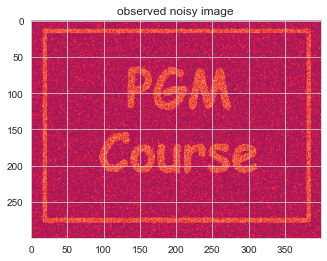

In [13]:
# Plotting the noisy image, and saving it

plt.figure()
plt.imshow(y)   
plt.title("observed noisy image")
plt.savefig('./PGM_class_plus_noise.png')

In [14]:
# Mean-Field Variational Inference
logodds = multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2) - \
          multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2)
logodds = np.reshape(logodds, (M, N))

# Initializing parameters
p1 = sigmoid(logodds)
mu = 2*p1-1  #mu_init

a = mu + 0.5 * logodds
qxp1 = sigmoid(+2*a)  #q_i(x_i=+1)
qxm1 = sigmoid(-2*a)  #q_i(x_i=-1)

logp1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=+1, cov=sigma**2), (M, N))
logm1 = np.reshape(multivariate_normal.logpdf(y.flatten(), mean=-1, cov=sigma**2), (M, N))

for i in tqdm(range(max_iter)):
    muNew = mu
    for ix in range(N):
        for iy in range(M):
            pos = iy + M*ix
            neighborhood = pos + np.array([-1,1,-M,M])            
            boundary_idx = [iy!=0,iy!=M-1,ix!=0,ix!=N-1]
            neighborhood = neighborhood[np.where(boundary_idx)[0]]            
            xx, yy = np.unravel_index(pos, (M,N), order='F')
            nx, ny = np.unravel_index(neighborhood, (M,N), order='F')
            
            Sbar = J*np.sum(mu[nx,ny])       
            muNew[xx,yy] = (1-rate)*muNew[xx,yy] + rate*np.tanh(Sbar + 0.5*logodds[xx,yy])
            ELBO[i] = ELBO[i] + 0.5*(Sbar * muNew[xx,yy])

    mu = muNew
            
    a = mu + 0.5 * logodds
    qxp1 = sigmoid(+2*a) #q_i(x_i=+1)
    qxm1 = sigmoid(-2*a) #q_i(x_i=-1)    
    Hx = -qxm1*np.log(qxm1+1e-10) - qxp1*np.log(qxp1+1e-10) #entropy        
    
    ELBO[i] = ELBO[i] + np.sum(qxp1*logp1 + qxm1*logm1) + np.sum(Hx)
    Hx_mean[i] = np.mean(Hx)            


running mean-field variational inference...


100%|██████████| 30/30 [00:49<00:00,  1.64s/it]


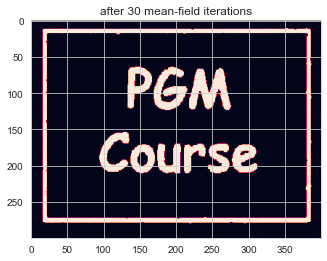

In [15]:
plt.figure()
plt.imshow(mu)
plt.title("after %d mean-field iterations" %max_iter)
plt.savefig('./PGM_ising_denoised.png')

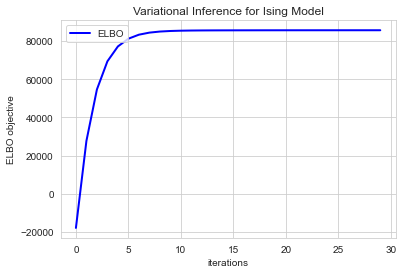

In [16]:
# Plotting the ELBO objective function value of Ising model
plt.figure()
plt.plot(ELBO, color='b', lw=2.0, label='ELBO')
plt.title('Variational Inference for Ising Model')
plt.xlabel('iterations'); plt.ylabel('ELBO objective')
plt.legend(loc='upper left')
plt.savefig('./PGM_VarInfer_ELBO.png')


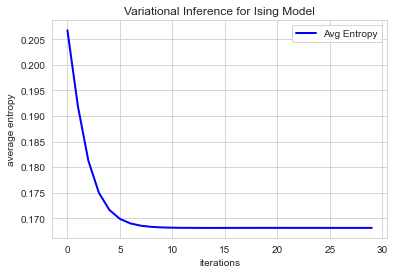

In [17]:
# Plotting the Average Entropy 
plt.figure()
plt.plot(Hx_mean, color='b', lw=2.0, label='Avg Entropy')
plt.title('Variational Inference for Ising Model')
plt.xlabel('iterations'); plt.ylabel('average entropy')
plt.legend(loc="upper right")
plt.savefig('./PGM_AvgEnt.png')